### Data analysis of MCS Data for selected Mars Year
NOTEBOOK CREATED WITH THE HELP OF VICTORIA CONCEPCION TO MAKE THE PLOTS FOR "TYPICAL" VORTEX SHAPE OF BOTH POLES

THE DATA IS BINNED FOR ALTITUDES BETWEEN 10 and 20 KM FOR THE NORTH POLE

Creating LatLon plots, vortex shape tendency, and polar projection plots of temperature data during MY

- Finding the border of the polar vortex at 170 K

 -  Where wind gradient is steepest, where the winds are the strongest

 -  Marks the border for the polar vortex in this analysis

In [1]:


#import packages
from scipy import interpolate
import matplotlib.animation as ani
import matplotlib.colors as colors
from tqdm import tqdm
import MCS_Vortex_modules as MCS
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import binned_statistic_2d as bin2d
from scipy.interpolate import pchip
import scipy.stats as stats
import pickle
from scipy.ndimage import gaussian_filter


#formating for plots
plt.rc('font', family='serif')
plt.rcParams['font.weight']= 'heavy'
plt.rcParams.update({'font.size': 12})

#polar projection
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from tqdm import tqdm 
import matplotlib.ticker as mticker
from scipy.integrate import trapz
import warnings

In [2]:
#binning in longitude and latitude:    
from MCS_Vortex_modules import Lat_Long_binning

#import the Polar vortex analysis functions:
from MCS_Vortex_modules import fill_gaps
from MCS_Vortex_modules import contour_fit
from MCS_Vortex_modules import centroid_point

In [36]:
#reading from parquet file
#df = pd.read_parquet('../Datasets/MCS_MY29_20071209_20081225.parquet.gzip'); yr = 29 ; missing_Ls = [0, 32, 107, 140] ; dups =[5,1,1,1]
#df = pd.read_parquet('../Datasets/MCS_MY30_20091026_20101112.parquet.gzip'); yr = 30 ; missing_Ls = [0, 149] ; dups = [24,1]
#df = pd.read_parquet('../Datasets/MCS_MY31_20110913_20120731.parquet.gzip'); yr = 31 ; missing_Ls = [26, 70, 148] ; dups = [1,1,33]
#df = pd.read_parquet('../Datasets/MCS_MY32_20130713_20150618.parquet.gzip'); yr = 32 ; missing_Ls = [1, 100, 110] ; dups = [2,1,8]
#df = pd.read_parquet('../Datasets/MCS_MY33_20150618_20170505.parquet.gzip'); yr = 33 ; missing_Ls = [101, 142, 172] ; dups = [3,1,5]
#df = pd.read_parquet('../Datasets/MCS_MY34_20170505_20190322.parquet.gzip'); yr = 34 ; missing_Ls = [0, 131, 144] ; dups = [80,7,2]
df = pd.read_parquet('../Datasets/MCS_MY35_20190322_20200408.parquet.gzip'); yr = 35 ; missing_Ls = [0,153] ; dups = [1,4]

In [37]:
#longitude bin size
longbinsiz = 5
latbinsiz = 5

#altitude range
#alt1 = 5 ; alt2 = 10
#alt1 = 10 ; alt2 = 15
#alt1 = 15 ; alt2 = 20
#alt1 = 20 ; alt2 = 25
#alt1 = 25 ; alt2 = 30
alt1 = 10; alt2 = 20


#latitude cut off:
latcut = -30 #for polar vortex area and longitude analyisis

# create a new dataframe that only includes the polar vortex of the south pole region (south polar vortex)
SPV = df[(df.LS <= 160)&(df.LS >=20)&(df.ALTITUDE <= alt2)&(df.ALTITUDE >= alt1)&(df.LATITUDE <= latcut)]
#resetting index of new dataframe
SPV = SPV.reset_index()
SPV = SPV.drop(['index'],axis = 1)

#bin the data
LatV,LongV, Vtemp = Lat_Long_binning(SPV,'temp',longbinsiz,latbinsiz,-90,latcut,-180,180)


names = list(Vtemp.keys())

#### Lat Long Plot of Temperature for MY

100%|█████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:03<00:00, 40.89it/s]


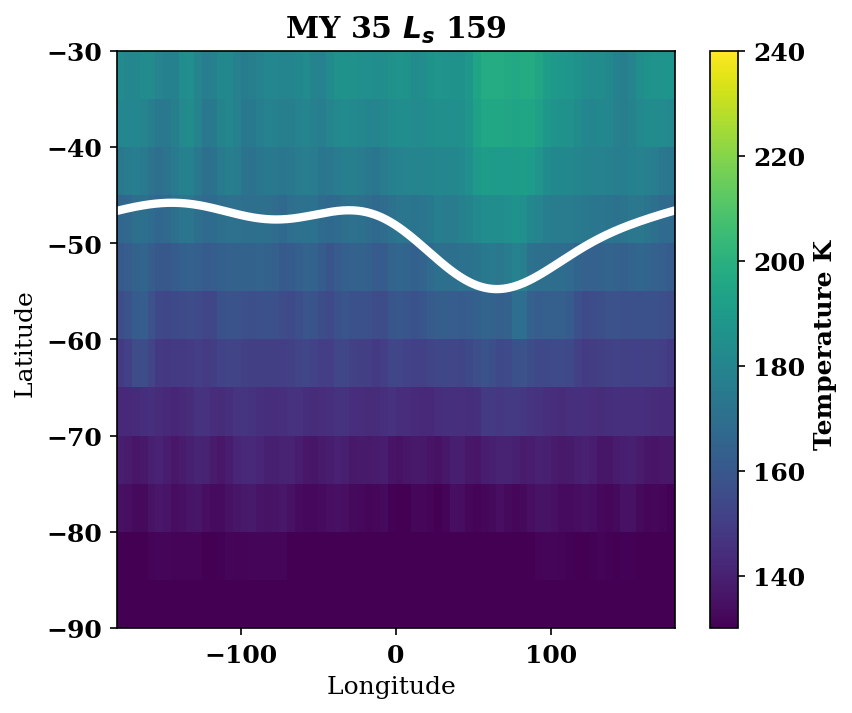

In [38]:
# create a matplotlib figure
figure = plt.figure(figsize=(6,5), dpi=150)

#min and max temp for colorbar:
tmin = 130
tmax = 240

# initialize the animator
writer = ani.FFMpegWriter(fps=12, bitrate=1000)
sc = plt.pcolormesh(LongV,LatV,Vtemp[names[0]].T, vmin=tmin, vmax=tmax)
cbar = plt.colorbar(sc)
cbar.set_label(label = 'Temperature K ',weight='bold')
m=np.zeros((361,361)) #matrix size of contour_fit product
with writer.saving(figure, 'flipbook/contours_disposable.mp4', figure.get_dpi()):
    for i in tqdm(range(len(names))):
        plt.cla()
        
        interp_temps = fill_gaps(Vtemp[names[i]].T)

        sc = plt.pcolormesh(LongV,LatV,interp_temps, vmin=tmin, vmax=tmax)
        cp = plt.contour(LongV[:-1]+2.5,LatV[:-1]+2.5,interp_temps, [170], colors='k',alpha=0)
        if len(cp.allsegs[0]) > 0:
            Longs, Lats = contour_fit(cp)
        else:
            continue
        plt.plot(Longs, Lats,color='white', linewidth =4)
        plt.ylabel('Latitude ')
        plt.xlabel('Longitude ')
        
        plt.title('MY '+str(yr)+ ' $L_s$ '+str(int(float(names[i]))), fontweight='bold')
        plt.ylim(-90,latcut)
        plt.xlim(-180,180)
        
        for j in range(len(Lats)):  #save contour lines as variable for use in pcolormesh 
            k=int(Lats[j])
            if  -361 < k < 361:
                m[k,j]=m[k,j]+1
            else:
                continue
        
    
        writer.grab_frame()
#remove blank parts of matrix and scale to match the shape of Long and Lat plot
m2=m.copy() #create copy of m to reshape 
m2= np.delete(m2, range(0,270), axis=0)
m2= np.delete(m2, range(60,90), axis=0)

m2=np.array(m2)

In [39]:
with open('SOUTH_MY'+str(yr)+'_SHAPE_CONTOURS.pickle', 'wb') as handle:
    pickle.dump(m2, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Longitudinal Direction Tendancy Plot

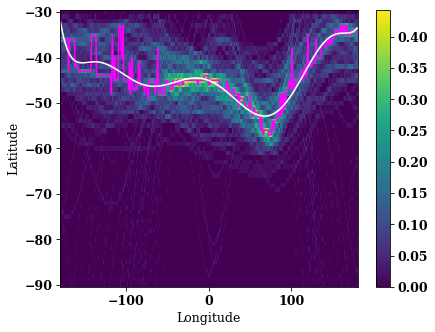

In [426]:
#remove blank parts of matrix and scale to match the shape of Long and Lat plot
m2=m.copy() #create copy of m to reshape 
m2= np.delete(m2, range(0,270), axis=0)
m2= np.delete(m2, range(60,90), axis=0)

m2=np.array(m2)
fig=plt.figure(dpi=75)
x2=np.linspace(-180,180,361)
y2=np.linspace(-90,-30,61)
pltm=plt.pcolormesh(x2,y2,m2/len(m2), shading='auto')

m3=np.argmax(m2, axis=0)
m4=m3-90 #only plot latitude above 30 degrees

#plot the contour
plt.plot(x2,m4,c='magenta')
#plot polyfit of contour
plt.plot(np.unique(x2), np.poly1d(np.polyfit(x2, m4 , 8))(np.unique(x2)), c='white')

#plt.title('MY29')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(pltm);

#### Polar Projection

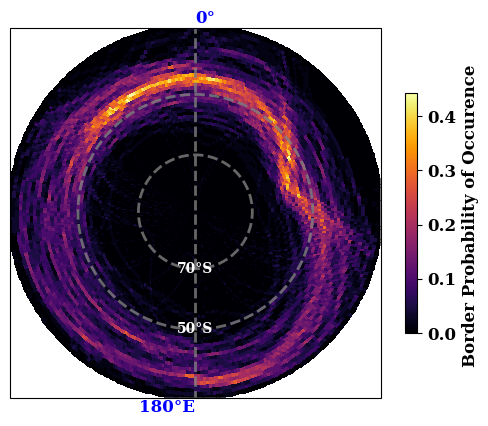

In [427]:

mplot = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=0.0, globe=None))
mplot.set_global()
mplot.set_extent([-180, 180, -30, -90], ccrs.PlateCarree())
tps = mplot.pcolormesh(x2,y2,m2/len(m2), transform=ccrs.PlateCarree(), shading='auto', cmap = 'inferno')
cb = plt.colorbar(tps, shrink=0.65)
cb.set_label(label = 'Border Probability of Occurence ',weight='bold')
gl = mplot.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.8, linestyle='--')

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator([-50,-70])
gl.xlocator = mticker.FixedLocator([0,180])
gl.xlabel_style = {'color': 'blue', 'weight': 'bold','rotation':0}
gl.ylabel_style = {'size': 10, 'color': 'white'}
#plt.title('MY 29')
#plt.savefig('South_Pole_Polar_Boundary.jpeg', dpi = 300)


#### All Mars years in one

In [9]:
with open('../Results/SOUTH_MY35_SHAPE_CONTOURS.pickle', 'rb') as handle:
    m35 = pickle.load(handle)

In [10]:
ALLMY = (m29 + m30 + m31 + m32 + m33 + m34 + m35)/7

In [13]:
m3=np.argmax(ALLMY, axis=0)
m4=m3-90 #only plot latitude above 30 degrees
x2=np.linspace(-180,180,361)

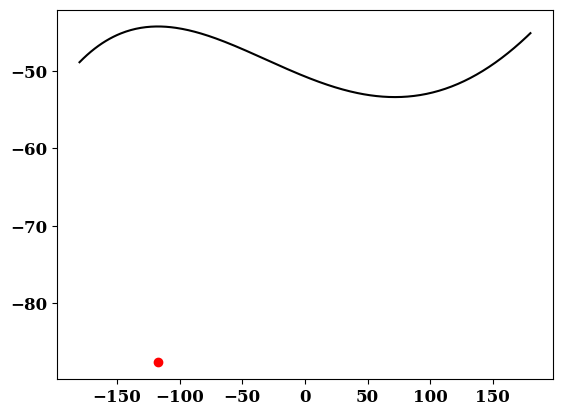

In [15]:
Latss = np.poly1d(np.polyfit(x2,m4 , 8))(np.unique(x2))
Longss = np.unique(x2)
plt.plot(np.unique(x2), np.poly1d(np.polyfit(x2,m4 , 4))(np.unique(x2)), c='black')
cen_long, cen_lat = centroid_point(Longss, Latss)
plt.plot(cen_long, cen_lat,'ro')

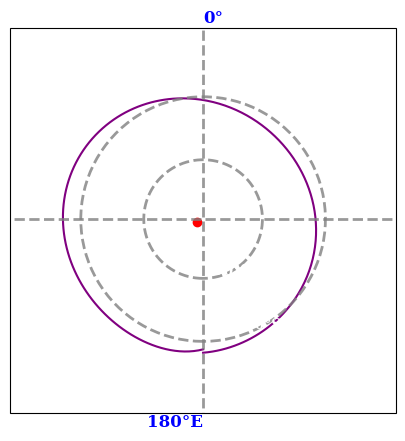

In [16]:
fig = plt.figure(figsize=(6,5))

mplot = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=0.0, globe=None))
mplot.set_global()
mplot.set_extent([-180, 180, -30, -90], ccrs.PlateCarree())
plt.plot(np.unique(x2), np.poly1d(np.polyfit(x2,m4 , 8))(np.unique(x2)), transform=ccrs.PlateCarree(),c='purple')
cen_long, cen_lat = centroid_point(Longss, Latss)
plt.plot(cen_long, cen_lat,'ro',transform=ccrs.PlateCarree())
#tps = mplot.pcolormesh(x2,y2,ALLMY/len(ALLMY), transform=ccrs.PlateCarree(),vmin =0,vmax=0.45 ,shading='auto', cmap = 'inferno')
#cb = plt.colorbar(tps, shrink=0.65)
#cb.set_label(label = 'Border Probability of Occurence ',weight='bold')
gl = mplot.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.8, linestyle='--')

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator([-50,-70])
gl.xlocator = mticker.FixedLocator([0,180,90,-90])
gl.xlabel_style = {'color': 'blue', 'weight': 'bold','rotation':0}
gl.ylabel_style = {'size': 10, 'color': 'white'}
#plt.title('MY 29')
#plt.savefig('South_Pole_Polar_Boundary.jpeg', dpi = 300)

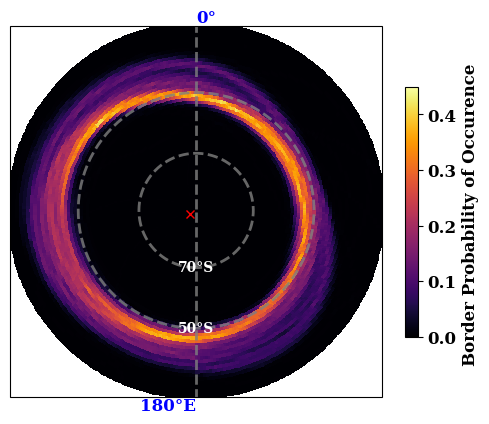

In [56]:
fig = plt.figure(figsize=(6,5))


x2=np.linspace(-180,180,361)
y2=np.linspace(-90,-30,61)

mplot = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=0.0, globe=None))
mplot.set_global()
mplot.set_extent([-180, 180, -30, -90], ccrs.PlateCarree())
tps = mplot.pcolormesh(x2,y2,ALLMY/len(ALLMY), transform=ccrs.PlateCarree(),vmin =0,vmax=0.45 ,shading='auto', cmap = 'inferno')
cb = plt.colorbar(tps, shrink=0.65)
cb.set_label(label = 'Border Probability of Occurence ',weight='bold')
gl = mplot.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.8, linestyle='--')
plt.plot(cen_long, cen_lat,'rx',transform=ccrs.PlateCarree())

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator([-50,-70])
gl.xlocator = mticker.FixedLocator([0,180])
gl.xlabel_style = {'color': 'blue', 'weight': 'bold','rotation':0}
gl.ylabel_style = {'size': 10, 'color': 'white'}
#plt.title('MY 29')
plt.savefig('South_Pole_Polar_Boundary_centroid.jpeg', dpi = 300)

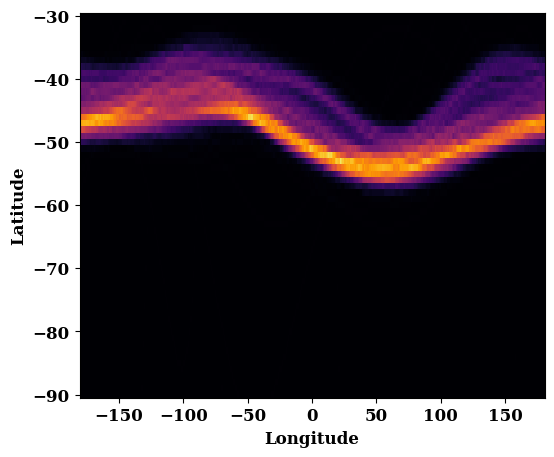

In [58]:
fig = plt.figure(figsize=(6,5))

x2=np.linspace(-180,180,361)
y2=np.linspace(-90,-30,61)
pltm=plt.pcolormesh(x2,y2,ALLMY/len(ALLMY), shading='auto',cmap = 'inferno',vmin = 0, vmax =0.45)
plt.xlabel('Longitude',weight = 'bold')
plt.ylabel('Latitude',weight = 'bold')
plt.savefig('South_Pole_Boundary.jpeg', dpi = 300)

In [39]:
def Fit_ellipse(contours_matrix):
    
    #first smoothen the matrix
    sigmaval = 2
    smoothed = gaussian_filter(contours_matrix, sigma=sigmaval)
    
    #Find the lat/long contour of the polar vortex by fitting the full sphere. 
    m3a =np.argmax(smoothed, axis=0)
    m3b = np.append(m3a,m3a)
    m3 = np.append(m3b,m3a)
    
    #create x series for fitting
    ny, nx = smoothed.shape
    xfit = range(len(m3))
    x = range(nx)
    
    #find the best fit, and transform into radians
    #define weights for the fit so that the end points match
    w = np.ones(len(m3))
    w[nx] = 20
    w[2*nx] = 20
    Full_fit = np.poly1d(np.polyfit(xfit,m3 , deg = 45,w=w))(xfit)
    Lats = Full_fit[nx:nx+nx]
    Longs = xfit[0:nx]
    

    return Lats


In [40]:
Ellipse = Fit_ellipse(ALLMY)

/var/folders/rn/195jf13x0b3_cfgl3cssb1gh0000gq/T/ipykernel_20640/2647929042.py:1: RankWarning: Polyfit may be poorly conditioned
  Ellipse = Fit_ellipse(ALLMY)


0.2632446290531702


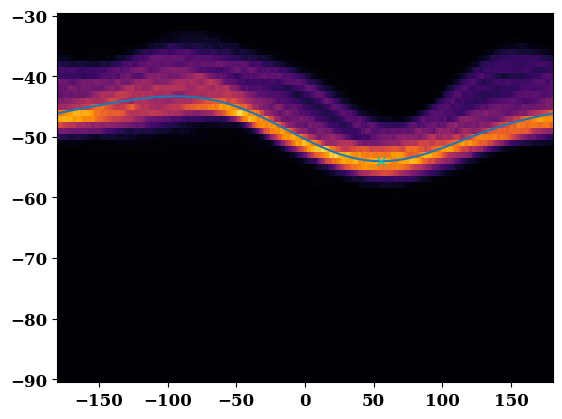

In [48]:
pltm=plt.pcolormesh(x2,y2,ALLMY/len(ALLMY), shading='auto',cmap = 'inferno',vmin = 0, vmax =0.45)

plt.plot(x2,Ellipse-90)
minpt = np.argmin(Ellipse-90)
maxpt = np.argmax(Ellipse-90)


plt.plot(x2[minpt],Ellipse[minpt]-90,'cx')
#plt.plot(x2[minpt+180],Ellipse[minpt+180]-90,'cx')
#plt.plot(x2[minpt+90],Ellipse[minpt+90]-90,'bx')
#plt.plot(x2[minpt-90],Ellipse[minpt-90]-90,'bx')


Axis1 = (Ellipse[minpt]-90 + Ellipse[minpt-180]-90)
Axis2 = (Ellipse[minpt-90]-90 + Ellipse[minpt+90]-90)
ellipticity = np.sqrt(((Axis1**2)-(Axis2**2))/(Axis1**2))
print(ellipticity)

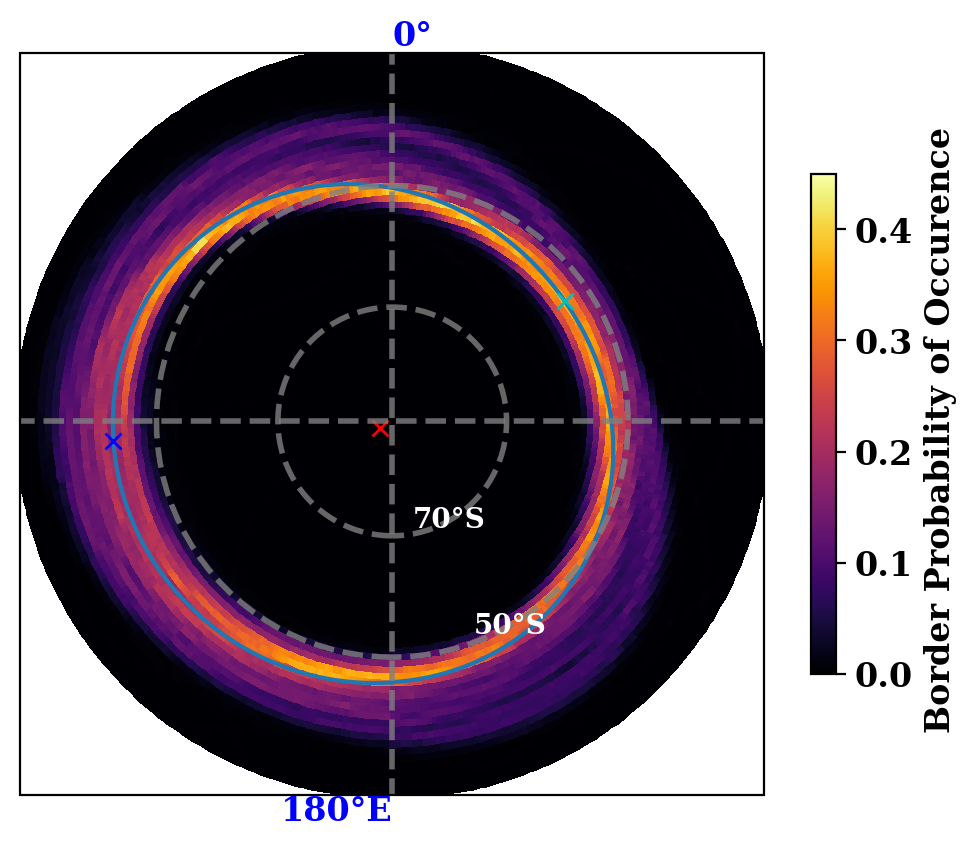

In [52]:
fig = plt.figure(figsize=(6,5),dpi = 200)


x2=np.linspace(-180,180,361)
y2=np.linspace(-90,-30,61)

mplot = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=0.0, globe=None))
mplot.set_global()
mplot.set_extent([-180, 180, -30, -90], ccrs.PlateCarree())
tps = mplot.pcolormesh(x2,y2,ALLMY/len(ALLMY), transform=ccrs.PlateCarree(),vmin =0,vmax=0.45 ,shading='auto', cmap = 'inferno')
cb = plt.colorbar(tps, shrink=0.65)
cb.set_label(label = 'Border Probability of Occurence ',weight='bold')
gl = mplot.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.8, linestyle='--')

mplot.plot(x2,Ellipse-90,transform  = ccrs.PlateCarree())
mplot.plot(x2[minpt],Ellipse[minpt]-90,'cx',transform  = ccrs.PlateCarree())
mplot.plot(x2[maxpt],Ellipse[maxpt]-90,'bx',transform  = ccrs.PlateCarree())
mplot.plot(cen_long, cen_lat,'rx',transform=ccrs.PlateCarree())


gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator([-50,-70])
gl.xlocator = mticker.FixedLocator([0,90,180,-90])
gl.xlabel_style = {'color': 'blue', 'weight': 'bold','rotation':0}
gl.ylabel_style = {'size': 10, 'color': 'white'}
#plt.title('MY 29')
#plt.savefig('South_Pole_Polar_Boundary_centroid.jpeg', dpi = 300)

In [54]:

Axis1 = 10
Axis2 = 9.7
ellipticity = np.sqrt(((Axis1**2)-(Axis2**2))/(Axis1**2))
print(ellipticity)

0.2431049156228646
